In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.constants import e
from tqdm.auto import tqdm
import pdb
%config InlineBackend.figure_formats = ['svg']

## Thermal detector

In [2]:
def det(t, T, C, Gb, Tb, G, P, t0):
    
    dT = P(t, t0)  # heat input
    dT += Gb * (Tb - T)  # coupling to temperature bath
    dT += np.dot(G, T)  # heat transfer from other components
    dT -= np.dot(np.diag(np.dot(G, np.ones(T.shape[0]))),T)  # heat transfer to other components
    dT /= C  # heat to temperature

    return dT

In [3]:
C = np.array([5e-5, 
              1e-4,
              5e-4])  # heat capacity, pJ/mK
Gb = np.array([5e-3, 
               0.,
               5e-3]) # heat cond to bath, pW/mK
Tb = 15.  # temp bath, mK
Gab = 1e-3
Gbc = 1e-3
G = np.array([[0., Gab, 0.], 
              [Gab, 0., Gbc], 
              [0., Gbc, 0.], ])  # heat cond between components, pW/mK
lamb = 0.01  # thermalization time, s
eps = 0.1  # share in thermometer
eps_ = np.array([eps, 
                 2*eps, 
                 (1-3*eps)])
delta = 0.  # share in thermometer
delta_ = np.array([delta, 
                 2*delta, 
                 (1-3*delta)])
t0 = 0.1  # onset time, s
er = 20 # keV

tpa = 10 # V^2/s
Rh = 10 # Ohm
keV_to_pJ = e * 1e3 * 1e12

def P_particle(x, t0):
    if t0 < x:
        retv = er*keV_to_pJ*eps_*np.exp(-(x-t0)/lamb)/lamb 
    else:
        retv = np.zeros(eps_.shape)
    return retv  # pW

def P_tp(x, t0):
    if t0 < x:
        retv = tpa/Rh*delta_*np.exp(-(x-t0)/lamb)
    else:
        retv = np.zeros(eps_.shape)
    return retv  # pW

t = np.linspace(0,1,10000)  # s

T0 = Tb * np.ones(C.shape[0])  # mK

In [4]:
%time Tp = odeint(det, T0, t, args=(C, Gb, Tb, G, P_particle, t0), tfirst=True)  # particle
%time Ttp = odeint(det, T0, t, args=(C, Gb, Tb, G, P_tp, t0), tfirst=True)  # testpulse

CPU times: user 17.6 ms, sys: 6.53 ms, total: 24.1 ms
Wall time: 18.4 ms
CPU times: user 14.3 ms, sys: 3.77 ms, total: 18.1 ms
Wall time: 15.2 ms


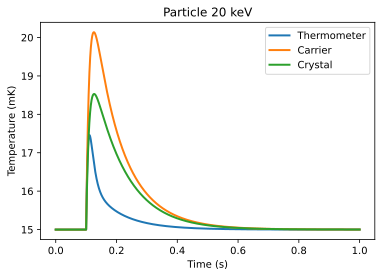

In [5]:
plt.plot(t, Tp[:, 0], label='Thermometer', c='C0', linewidth=2)
plt.plot(t, Tp[:, 1], label='Carrier', c='C1', linewidth=2)
plt.plot(t, Tp[:, 2], label='Crystal', c='C2', linewidth=2)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Temperature (mK)')
plt.title('Particle {} keV'.format(er))
plt.show()

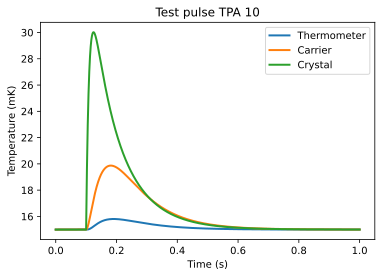

In [6]:
plt.plot(t, Ttp[:, 0], label='Thermometer', c='C0', linewidth=2)
plt.plot(t, Ttp[:, 1], label='Carrier', c='C1', linewidth=2)
plt.plot(t, Ttp[:, 2], label='Crystal', c='C2', linewidth=2)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Temperature (mK)')
plt.title('Test pulse TPA {}'.format(tpa))
plt.show()

## Temperature dependent couplings and capacities

In [7]:
def det_(t, T, C, Gb, Tb, G, P, t0, a, b, ):
    
    dT = P(t, t0)  # heat input
    dT += (Gb*(T/Tb)**a) * (Tb - T)  # coupling to temperature bath
    dT += np.dot(G*(T/Tb)**a, T)  # heat transfer from other components
    dT -= np.dot(np.diag(np.dot(G*(T/Tb)**a, np.ones(T.shape[0]))),T)  # heat transfer to other components
    dT /= (C*(T/Tb)**b)  # heat to temperature

    return dT

In [8]:
a = 4  # couplings power law
b = 3  # capacities power law

%time Tp_ = odeint(det_, T0, t, args=(C, Gb, Tb, G, P_particle, t0, a, b), tfirst=True)  # particle
%time Ttp_ = odeint(det_, T0, t, args=(C, Gb, Tb, G, P_tp, t0, a, b), tfirst=True)  # testpulse

CPU times: user 27.4 ms, sys: 6.59 ms, total: 33.9 ms
Wall time: 28.1 ms
CPU times: user 26.9 ms, sys: 6.64 ms, total: 33.5 ms
Wall time: 27.4 ms


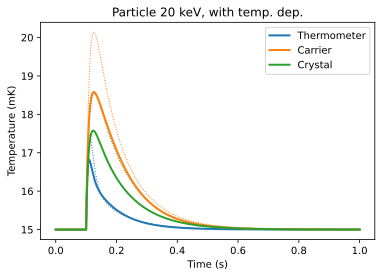

In [9]:
plt.plot(t, Tp[:, 0], c='C0', linewidth=1, linestyle='dotted')
plt.plot(t, Tp[:, 1], c='C1', linewidth=1, linestyle='dotted')
plt.plot(t, Tp[:, 2], c='C2', linewidth=1, linestyle='dotted')
plt.plot(t, Tp_[:, 0], label='Thermometer', c='C0', linewidth=2)
plt.plot(t, Tp_[:, 1], label='Carrier', c='C1', linewidth=2)
plt.plot(t, Tp_[:, 2], label='Crystal', c='C2', linewidth=2)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Temperature (mK)')
plt.title('Particle {} keV, with temp. dep.'.format(er))
plt.show()

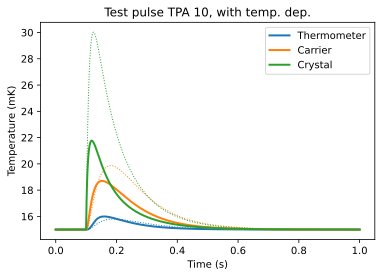

In [10]:
plt.plot(t, Ttp[:, 0], c='C0', linewidth=1, linestyle='dotted')
plt.plot(t, Ttp[:, 1], c='C1', linewidth=1, linestyle='dotted')
plt.plot(t, Ttp[:, 2], c='C2', linewidth=1, linestyle='dotted')
plt.plot(t, Ttp_[:, 0], label='Thermometer', c='C0', linewidth=2)
plt.plot(t, Ttp_[:, 1], label='Carrier', c='C1', linewidth=2)
plt.plot(t, Ttp_[:, 2], label='Crystal', c='C2', linewidth=2)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Temperature (mK)')
plt.title('Test pulse TPA {}, with temp. dep.'.format(tpa))
plt.show()